# 주제 : 노키즈 존은 초등학교, 유치원 주변에 많을까? 
<br> 노키즈 존(No kids Zone)은 영유아 및 어린이의 입장을 금지하는 업소를 뜻한다. 노키즈 존은 아이들의 소란스러운 행동과 부모의 방관으로 인한 업소 이용객들의 불만, 그리고 업장 내 안전사고의 책임을 업주에게 일부 지우는 법원 판결로 인해 점점 더 확산되고 있는 추세이다.<br> 이런 노키즈 존을 선호하는 사람들이 있는 반면 노키즈 존에 대하여 아이들을 차별하는 업소가 늘어나는 것은 장기적으로 저출산을 더욱 가속화 시키게 될 것이라는 우려도 있다.<br>
이번 프로젝트에서는 서울시 노키즈 존의 위치 분포를 통해 노키즈 존을 선호하는 곳의 특성을 파악하고, 아이들이 있는 가정의 불편을 최소화 할 수 있으면서도 노키즈 존이 공존할 수 있는 방안을 찾아보고자 한다.

## 가설 수립
<br>
<strong>가설 1</strong>: 노키즈 존은 초등학교 및 유치원 주변(아이들 인구 수가 많은 곳)에 적을 것이다. <br>
<strong>가설 2</strong>: 초등학교 및 유치원 주변에 노키즈 존이 많을수록 그 지역의 가족 친화도가 낮을 것이다. <br>
<strong>가설 3</strong>: 노키즈 존은 해당 지역의 경제적 수준이 높을수록 많을 것이다. </strong>

## 데이터 수집 소스 및 방법
<br>
1. <strong>노키즈 존 매장 위치 데이터</strong> (크롤링 코드 별도 첨부 ```nokidsZone_crawler.py```) <br>
https://www.google.com/maps/d/u/0/viewer?mid=1XNvlhjVsrQFtelWfLapc76MiJ9c&femb=1&ll=36.865369953439746%2C127.1456959437113&z=8 <br><br>
2. <strong>서울시 초등학교, 유치원 위치 데이터</strong><br>
Daum 지도에서 ("서울 초등학교", "서울 유치원") 각각의 키워드를 검색어로 넣어 ScrapeStorm 프로그램을 통해 크롤링<br>
<br>[1,2번의 직접 얻은 데이터가 1000 row가 넘었고, 확인하고자 하는 가설 관련 데이터를 개인이 직접 수집하기엔 한계가 있어 아래의 3가지 데이터들은 기존 데이터를 가공하여 사용하였습니다.]<br><br>
3. <strong>가족친화도</strong> (기존 데이터 받아와서 가공) : https://data.seoul.go.kr/dataList/10310/S/2/datasetView.do <br>
<br>
4. <strong>소득소비 데이터</strong> (기존 데이터 받아와서 가공) : https://data.seoul.go.kr/dataList/OA-22167/S/1/datasetView.do<br>
<br>
5. <strong>서울시 인구 분포</strong> (기존 데이터 받아와서 가공) : https://data.seoul.go.kr/dataList/10718/S/2/datasetView.do

## 데이터 전처리
사전에 ```nokidsZone.csv```, ```Elementary_school.csv```, ```kindergarten.csv``` 각 파일의 Address 컬럼의 도로명 주소로 Kakao API를 통해 위도, 경도를 받아 latitude, longitude 컬럼을 추가하였음. (```addr_to_latlon.py``` 파일 별도 첨부)

In [1]:
import pandas as pd
import folium
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [2]:
nokids_df = pd.read_csv('nokidsZone.csv',encoding='utf-8-sig')
nokids_df = nokids_df[nokids_df['Address'].str.contains('서울')] # 소재지가 서울인 노키즈 존만 뽑음
school_df = pd.read_csv('Elementary_school.csv',encoding='utf-8-sig')
kindergarten_df = pd.read_csv('kindergarten.csv',encoding='utf-8-sig')
population_df = pd.read_csv('population_seoul.csv',encoding='utf-8-sig')

```population_seoul.csv``` 는 서울 자치구별 0세부터 100세 이상까지의 연령대별 인구수 데이터인데 일반적으로 노키즈존에서 제한 기준이 되는 연령이 10세에서 13세쯤인 것을 고려하여 '0\~4세', '5\~9세', '10~14세' 3개 컬럼의 데이터만 따로 뽑아 '합계' 컬럼을 새로 계산했다.(원본 파일엔 '합계' 컬럼이 전연령대에 대한 합계임)

In [3]:
population_df = population_df[population_df['항목'] == '계']
columns = ['자치구별', '합계', '0~4세', '5~9세', '10~14세']
population_df = population_df[columns]
population_df['어린이 합계'] = population_df[['0~4세', '5~9세', '10~14세']].sum(axis=1)
population_df['어린이 비율'] = population_df['어린이 합계'] / population_df['합계']
population_df.drop(columns=['합계'], inplace=True)
population_df.rename(columns={'어린이 합계': '합계'}, inplace=True)
population_df.reset_index(drop=True, inplace=True)

In [4]:
population_df

,자치구별,0~4세,5~9세,10~14세,합계,어린이 비율
0,종로구,2470,3689,4706,10865,0.072169
1,중구,2822,3162,3123,9107,0.069091
2,용산구,5327,6536,6959,18822,0.084240
3,성동구,7811,8917,8343,25071,0.088198
4,광진구,6361,9015,11437,26813,0.076407
5,동대문구,7981,10304,10853,29138,0.080891
6,중랑구,8517,10481,11591,30589,0.078953
7,성북구,9619,14081,16488,40188,0.091984
8,강북구,4447,6892,8924,20263,0.069543
9,도봉구,5514,8420,10473,24407,0.079022


In [5]:
from folium.plugins import MarkerCluster
m = MarkerCluster()

geo_json='https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json'

pop2=population_df[['자치구별','합계']]
pop2.columns=['name','values']
pop2=pop2.sort_values(by='name')
pop2['name']=pop2['name'].apply(lambda x: re.compile('[가-힣]+').findall(x)[0])

m=folium.Map(
    location=[37.566345,126.977893],
    tiles='CartoDB Positron',
    zoom_start = 11,
)

# 어린이 비율이 높을수록 따라 자치구별 색상이 진해지도록
folium.Choropleth(
    geo_data=geo_json,
    data=pop2,
    columns=['name','values'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.3,
).add_to(m)

# 각 초등학교 위치에 파란색 점 추가
for idx, row in school_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(m)

# 각 유치원 위치에 보라색 점 추가
for idx, row in kindergarten_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color='purple',
        fill=True,
        fill_color='purple'
    ).add_to(m)

for idx, row in nokids_df.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['Name'],
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m)
    
m

### 가설 검증 전 기본 가정에 대한 검증
위에서 세운 가설들은 초등학교와 유치원 수가 많을 수록 아이들 인구가 많을 것이라는 기본 가정이 깔려있다. 그렇기에 본격적인 분석을 하기 전에 초등학교와 유치원 수가 아이들의 인구수를 대변할 수 있을지 먼저 확인하였다.<br>
내가 구한 서울시 자치구별 연령대별 인구수 데이터 ```population.csv```가 4살 단위로 나뉘어져 있어서 불가피하게 아래와 같은 방식으로 상관계수를 확인하였다.
- 유치원에 다니는 연령대인 5\~7세가 포함된 5\~9세와 유치원 수를 비교 
- 초등학교에 다니는 연령대인 8\~13세가 포함된 5\~9세, 10~14세 데이터를 합쳐 초등학교 수와 비교

상관계수 확인 결과 유치원 수와 아동 인구수 간의 상관계수가 초등학교 수와 아동 인구수에 비해 상대적으로 낮았는데, <br>
유치원의 경우 비교적 원생 수를 자유롭게 정할 수 있기 때문에 이런 결과나 나온 것으로 보인다. <br>
결과적으로 이정도면 초등학교 수, 유치원 수 둘다 아동 인구수를 대변하는 편이라고 판단하고 분석을 진행하였다.

In [6]:
# Address 컬럼에서 자치구 정보 추출
def extract_district(address):
    match = re.search(r'서울\s(\S+구)', address)
    if match:
        return match.group(1)
    return None

school_df['자치구'] = school_df['Address'].apply(extract_district)
kindergarten_df['자치구'] = kindergarten_df['Address'].apply(extract_district)

school_counts = school_df['자치구'].value_counts().reset_index()
school_counts.columns = ['자치구', '초등학교 수']

kindergarten_counts = kindergarten_df['자치구'].value_counts().reset_index()
kindergarten_counts.columns = ['자치구', '유치원 수']

schkind_counts = pd.merge(school_counts, kindergarten_counts, on='자치구', how='outer').fillna(0)

analysis_df = pd.merge(population_df, schkind_counts, left_on='자치구별', right_on='자치구', how='inner')
analysis_df.drop(columns=['자치구'], inplace=True)
analysis_df.rename(columns={'자치구별': '자치구'}, inplace=True)
analysis_df

,자치구,0~4세,5~9세,10~14세,합계,어린이 비율,초등학교 수,유치원 수
0,종로구,2470,3689,4706,10865,0.072169,13,17
1,중구,2822,3162,3123,9107,0.069091,12,14
2,용산구,5327,6536,6959,18822,0.084240,15,18
3,성동구,7811,8917,8343,25071,0.088198,21,32
4,광진구,6361,9015,11437,26813,0.076407,21,38
5,동대문구,7981,10304,10853,29138,0.080891,21,34
6,중랑구,8517,10481,11591,30589,0.078953,24,38
7,성북구,9619,14081,16488,40188,0.091984,29,53
8,강북구,4447,6892,8924,20263,0.069543,14,24
9,도봉구,5514,8420,10473,24407,0.079022,23,36


아동 인구수와 초등학교 수 상관계수: 0.8805805019081447
아동 인구수와 유치원 수 상관계수: 0.723042674675433


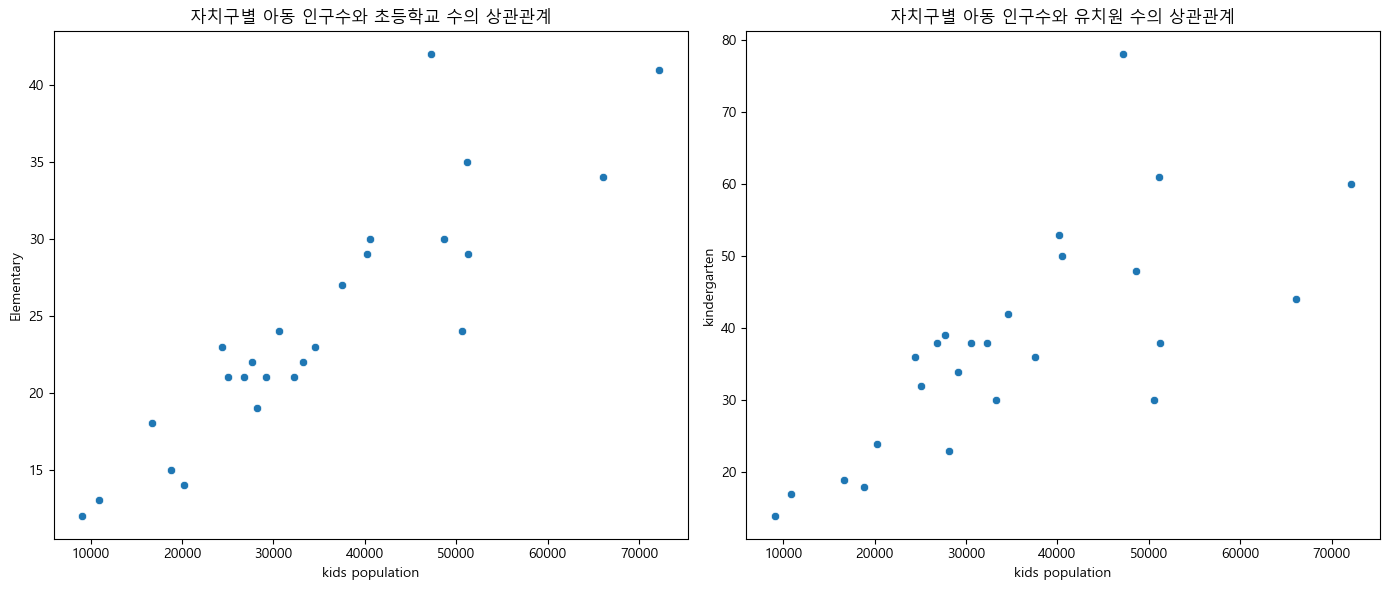

In [7]:
corr_elem =(analysis_df['5~9세']+analysis_df['10~14세']).corr(analysis_df['초등학교 수'])
corr_kinder = analysis_df['5~9세'].corr(analysis_df['유치원 수'])
print(f'아동 인구수와 초등학교 수 상관계수: {corr_elem}')
print(f'아동 인구수와 유치원 수 상관계수: {corr_kinder}')

# 시각화
plt.figure(figsize=(14, 6))
plt.rc('font', family='Malgun Gothic')
plt.subplot(1, 2, 1)
sns.scatterplot(x='합계', y='초등학교 수', data=analysis_df)
plt.title('자치구별 아동 인구수와 초등학교 수의 상관관계')
plt.xlabel('kids population')
plt.ylabel('Elementary')

plt.subplot(1, 2, 2)
sns.scatterplot(x='합계', y='유치원 수', data=analysis_df)
plt.title('자치구별 아동 인구수와 유치원 수의 상관관계')
plt.xlabel('kids population')
plt.ylabel('kindergarten')

plt.tight_layout()
plt.show()

## 가설 1 검증
<br> <strong>가설 1: 노키즈존은 초등학교 및 유치원 주변(아이들 인구 수가 많은 곳)에 적을 것이다.</strong><br>
가설1을 검증하기 위해 총 3가지의 방식으로 분석해보았다.
- 반경 2km 내의 노키즈존 주변 초등학교/유치원 수가 얼마나 많은지 자치구별로 막대그래프를 통해 확인
- 자치구별 노키즈존 수와 초등학교/유치원 수의 상관계수
- 자치구별 노키즈존 수와 면적(1km2)당 초등학교/유치원 밀집도의 상관계수
- 노키즈 존이 있는 자치구와 없는 자치구 간의 초등학교/유치원 밀집도에 대한 ANOVA 분석
<br><br>
결론적으로는 상관계수들이 모두 음수로 나왔기 때문에 노키즈존의 분포와 초등학교/유치원의 분포가 다소 반비례한 것이지만, 둘다 0에 가까워 노키즈존이 초등학교/유치원 유무와 상관없이 분포해 있는것으로 보인다.<br>
또한 ANOVA 분석 결과 p-value가 0.05보다 큰것으로 보아 초등학교 및 유치원 밀집도가 노키즈 존의 유무에 영향을 미치지 않는다는 것을 알 수 있다.

In [8]:
# 반경 2km 내의 노키즈 존 주변 초등학교 및 유치원 수 계산
def count_schools_within_radius(center_df, locations_df, radius=2.0):
    counts = []
    for _, center_row in center_df.iterrows():
        center_location = (center_row['latitude'], center_row['longitude'])
        count = 0
        for _, location_row in locations_df.iterrows():
            location = (location_row['latitude'], location_row['longitude'])
            if geodesic(center_location, location).km <= radius:
                count += 1
        counts.append(count)
    return counts

nokidsZone_df = nokids_df.reset_index()
nokidsZone_df['schools'] = count_schools_within_radius(nokids_df, school_df)
nokidsZone_df['kindergartens'] = count_schools_within_radius(nokids_df, kindergarten_df)
nokidsZone_df

,index,Name,Address,latitude,longitude,schools,kindergartens
0,4,카쿠,서울특별시 강동구 성내제1동 성안로 45,37.527890,127.130507,16,22
1,16,아워온즈,서울특별시 서대문구 연희맛로 45,37.568863,126.931198,13,21
2,71,더가미,서울특별시 강남구 선릉로125길 10,37.514948,127.041059,8,8
3,72,리틀 앤 머치,서울특별시 강남구 학동로56길 49 성림빌딩,37.514027,127.043521,8,8
4,73,모던눌랑 센트럴시티점,서울특별시 서초구 사평대로 205,37.504492,127.007845,12,13
...,...,...,...,...,...,...,...
76,433,뷰클런즈,서울특별시 송파구 백제고분로43길 10,37.508360,127.109589,16,24
77,437,굴림,서울특별시 성동구 성수이로5길 1 1층,37.536279,127.053578,9,15
78,440,더리버 끌라비에,서울특별시 서초구 반포동 1338,37.506183,126.986919,9,15
79,442,알레즈,서울특별시 용산구 독서당로 89,37.534765,127.010279,9,13


마포구는 어린이 인구가 33000명 정도인 곳으로 어린이가 적은 편인 자치구이며, 초등학교/유치원 수 또한 그닥 많지 않은 편이다. 그럼에도 불구하고 유난히 노키즈존이 초등학교/유치원 밀집된 곳에 위치해있는 것을 아래의 막대 그래프로부터 확인할 수 있다.

<Figure size 1200x600 with 0 Axes>

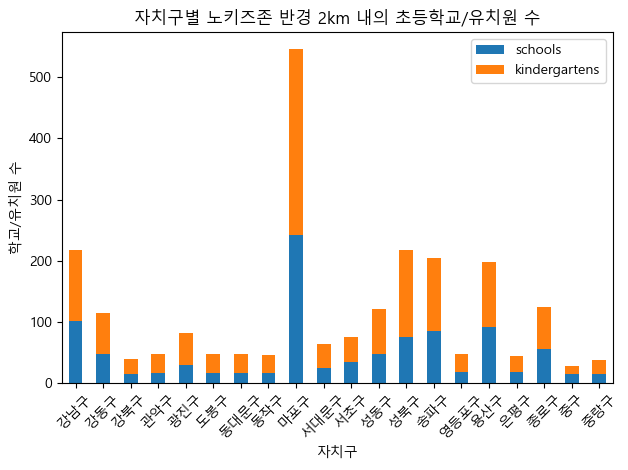

In [9]:
import pandas as pd

def extract_district(address):
    return address.split()[1]

nokidsZone_df['자치구'] = nokidsZone_df['Address'].apply(extract_district)
district_counts = nokidsZone_df.groupby('자치구')[['schools', 'kindergartens']].sum()

plt.figure(figsize=(12, 6))

district_counts.plot(kind='bar', stacked=True)

plt.title('자치구별 노키즈존 반경 2km 내의 초등학교/유치원 수')
plt.xlabel('자치구')
plt.ylabel('학교/유치원 수')
plt.xticks(rotation=45)

# 그래프 표시
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()


#### 상관분석

In [10]:
def extract_district(address):
    return address.split()[1]

schools_df = school_df
kindergartens_df = kindergarten_df
nokidsZone_df['자치구'] = nokidsZone_df['Address'].apply(extract_district)
schools_df['자치구'] = schools_df['Address'].apply(extract_district)
kindergartens_df['자치구'] = kindergartens_df['Address'].apply(extract_district)

nokids_district_counts = nokidsZone_df['자치구'].value_counts().reset_index()
nokids_district_counts.columns = ['자치구', '노키즈존 수']

analysis_df = pd.merge(analysis_df, nokids_district_counts, on='자치구', how='left')
analysis_df['노키즈존 수'] = analysis_df['노키즈존 수'].fillna(0)

자치구별 초등학교/유치원 수와 노키즈존 수 상관계수: -0.14523628382873705


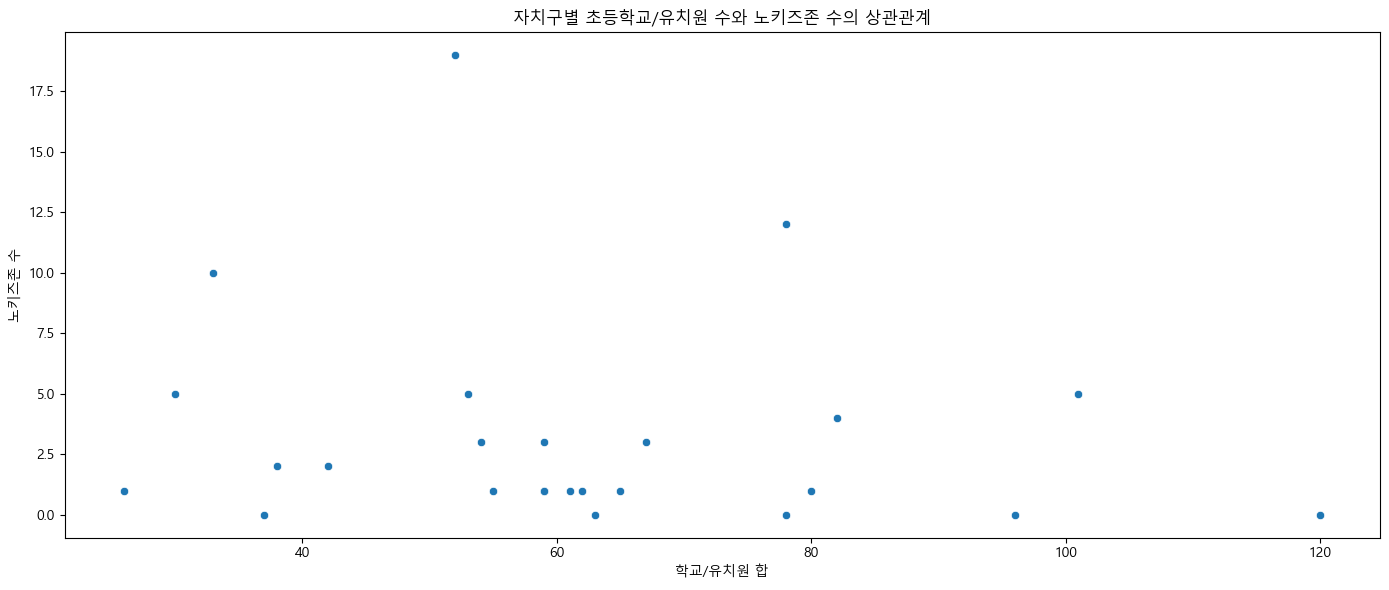

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 상관계수 계산
analysis_df['학교/유치원 합'] = analysis_df['초등학교 수']+analysis_df['유치원 수']
correlation = analysis_df['학교/유치원 합'].corr(analysis_df['노키즈존 수'])

print(f'자치구별 초등학교/유치원 수와 노키즈존 수 상관계수: {correlation}')

# 시각화
plt.figure(figsize=(14, 6))

# plt.subplot(1,2,1)
sns.scatterplot(x='학교/유치원 합', y='노키즈존 수', data=analysis_df)
plt.title('자치구별 초등학교/유치원 수와 노키즈존 수의 상관관계')
plt.xlabel('학교/유치원 합')
plt.ylabel('노키즈존 수')

plt.tight_layout()
plt.show()


초등학교/유치원 밀집도와 노키즈 존 수의 상관관계: -0.39623924753164863


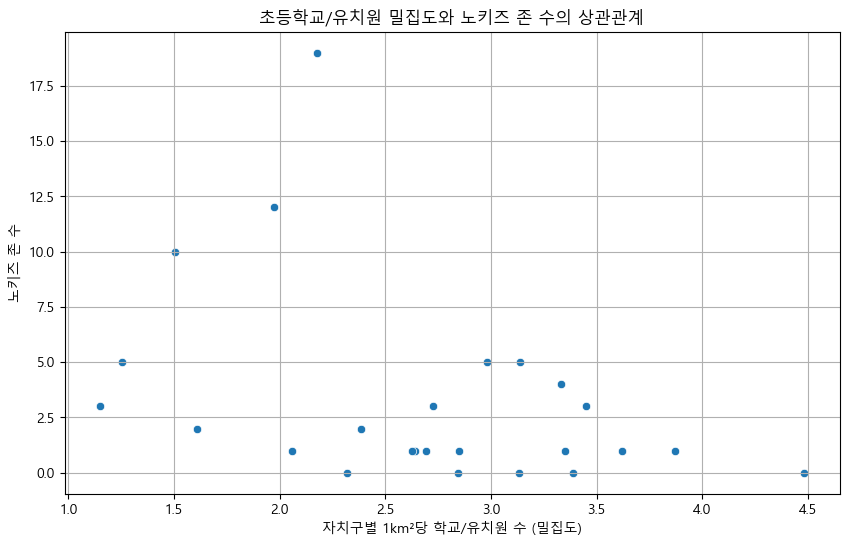

In [12]:
gu_area = {
    '강남구': 39.5, '강동구': 24.6, '강북구': 23.6, '강서구': 41.4, '관악구': 29.6,
    '광진구': 17.1, '구로구': 20.1, '금천구': 13.0, '노원구': 35.4, '도봉구': 20.7,
    '동대문구': 14.2, '동작구': 16.3, '마포구': 23.9, '서대문구': 17.6, '서초구': 47.0,
    '성동구': 16.9, '성북구': 24.6, '송파구': 33.9, '양천구': 17.4, '영등포구': 24.6,
    '용산구': 21.9, '은평구': 29.7, '종로구': 23.9, '중구': 9.9, '중랑구': 18.5
}

gu_area_df = pd.DataFrame(list(gu_area.items()), columns=['자치구', '면적_km2'])

gu_edu_counts = analysis_df.groupby('자치구')[['초등학교 수', '유치원 수']].sum()
gu_edu_counts['total_edu'] = gu_edu_counts['초등학교 수'] + gu_edu_counts['유치원 수']

gu_edu_counts = gu_edu_counts.merge(gu_area_df, on='자치구')
gu_edu_counts['edu_density'] = gu_edu_counts['total_edu'] / gu_edu_counts['면적_km2']

gu_nokids_counts = nokidsZone_df['자치구'].value_counts().reset_index()
gu_nokids_counts.columns = ['자치구', '노키즈 존 수']

merged_df = pd.merge(gu_edu_counts, gu_nokids_counts, on='자치구', how='left')
merged_df.fillna(0, inplace=True)  # 노키즈 존 수가 없는 자치구는 0으로 대체

correlation = merged_df['edu_density'].corr(merged_df['노키즈 존 수'])
print(f"초등학교/유치원 밀집도와 노키즈 존 수의 상관관계: {correlation}")

plt.figure(figsize=(10, 6))
sns.scatterplot(x='edu_density', y='노키즈 존 수', data=merged_df)
plt.title('초등학교/유치원 밀집도와 노키즈 존 수의 상관관계')
plt.xlabel('자치구별 1km²당 학교/유치원 수 (밀집도)')
plt.ylabel('노키즈 존 수')
plt.grid(True)
plt.show()

#### ANOVA 분석
p-value가 0.108로 0.05보다 크기 때문에, 노키즈 존이 있는 자치구와 없는 자치구 간의 초등학교 및 유치원 밀집도에 유의미한 차이가 없다고 볼 수 있다. 즉, 초등학교 및 유치원 밀집도가 노키즈 존의 유무에 영향을 미치지 않는다는 결론을 내릴 수 있다.

F-statistic: 2.7887516503288348, p-value: 0.1084835489416289


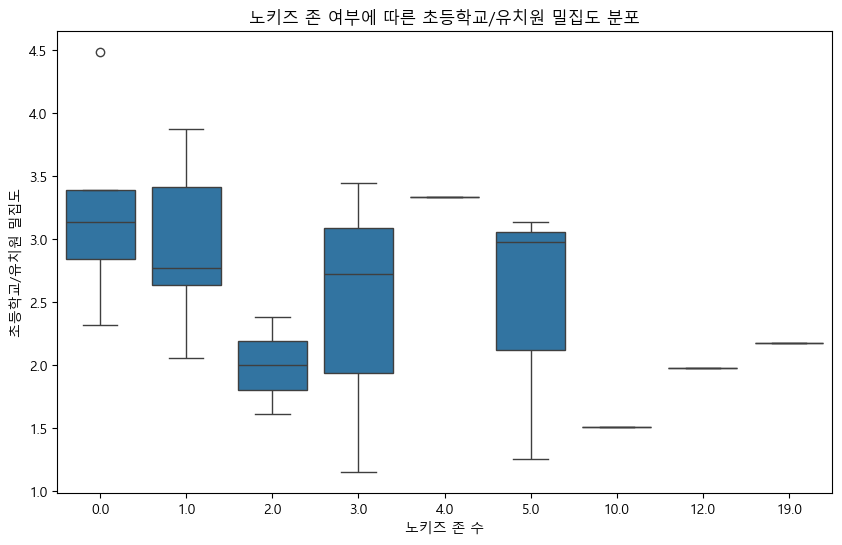

In [13]:
# ANOVA 분석을 통한 노키즈 존이 있는 자치구와 없는 자치구 간의 초등학교 및 유치원 밀집도 비교

from scipy.stats import f_oneway

with_nokids_density = merged_df[merged_df['노키즈 존 수'] > 0]['edu_density']
without_nokids_density = merged_df[merged_df['노키즈 존 수'] == 0]['edu_density']

f_stat, p_value = f_oneway(with_nokids_density, without_nokids_density)
print(f"F-statistic: {f_stat}, p-value: {p_value}")

plt.figure(figsize=(10, 6))
sns.boxplot(x='노키즈 존 수', y='edu_density', data=merged_df)
plt.title('노키즈 존 여부에 따른 초등학교/유치원 밀집도 분포')
plt.xlabel('노키즈 존 수')
plt.ylabel('초등학교/유치원 밀집도')
plt.show()


## 가설2, 가설3 검증
<strong>가설 2: 초등학교 및 유치원 주변에 노키즈 존이 많을수록 그 지역의 가족 친화도가 낮을 것이다. <br>
가설 3: 노키즈 존은 해당 지역의 경제적 수준이 높을수록 많을 것이다.</strong> <br><br>
가설 2와 가설 3을 동시에 확인하기 위해 Lasso 회귀를 사용하여 분석을 아래와 같은 과정으로 진행한다.
- 회귀에 사용할 feature인 가족 친화도와 경제 수준간의 상관관계, 다중공선성을 확인한다.
- Lasso 회귀를 통해 나온 가중치를 통해 노키즈존과 가족친화도, 노키즈존과 경제 수준간의 관계를 분석한다.

In [14]:
columns = [analysis_df.columns[0], analysis_df.columns[8],  analysis_df.columns[9]]
regression_df = analysis_df[columns]

In [15]:
affinity_df = pd.read_csv('affinity.csv', encoding='utf-8-sig')
affinity_df['가족친화도'] = affinity_df.iloc[:, 1:6].sum(axis=1)
affinity_df = affinity_df[['자치구', '가족친화도']]
economy_df = pd.read_csv('economy.csv', encoding = 'utf-8-sig')

regression_df = pd.merge(regression_df, affinity_df, on='자치구', how='left')
regression_df = pd.merge(regression_df, economy_df, on='자치구', how='left')
regression_df

,자치구,노키즈존 수,학교/유치원 합,가족친화도,월평균소득
0,종로구,5.0,30,30.96,3725859
1,중구,1.0,26,30.65,3513603
2,용산구,10.0,33,29.54,3971498
3,성동구,5.0,53,30.32,3734499
4,광진구,3.0,59,30.32,3192971
5,동대문구,1.0,55,30.48,3030256
6,중랑구,1.0,62,29.88,2598785
7,성북구,4.0,82,29.77,3281773
8,강북구,2.0,38,29.87,2547460
9,도봉구,1.0,59,30.16,2785111


### feature 간의 상관관계, 다중공선성 확인
feature간의 상관관계는 낮게 나왔지만, '가족친화도'와 '월평균소득'의 VIF가 10을 훌쩍 넘었기 때문에 두 feature 중 VIF가 더 큰 '가족친화도' 컬럼을 제외하기로 하였다. 나머지 feature들간의 상관관계, 다중공선성을 또 확인하였고, 둘다 낮게 나왔기에 '월평균소득', '학교/유치원 합' feature들을 가지고 regression을 진행하기로 하였다.

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 상관관계 확인
correlation_matrix = regression_df[['학교/유치원 합', '가족친화도', '월평균소득']].corr()

# 다중공선성 확인
X = regression_df[['학교/유치원 합', '가족친화도', '월평균소득']]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

In [17]:
correlation_matrix

,학교/유치원 합,가족친화도,월평균소득
학교/유치원 합,1.000000,0.032584,0.050089
가족친화도,0.032584,1.000000,0.208004
월평균소득,0.050089,0.208004,1.000000


In [18]:
vif_data

,feature,VIF
0,학교/유치원 합,8.777233
1,가족친화도,39.330459
2,월평균소득,32.906025


'가족친화도' 컬럼을 제외한 '학교/유치원 합', '월평균소득' 컬럼들간의 상관관계, 다중공선성 확인결과 상관관계도 0에 가깝고, 다중공선성도 10보다 작아 두 feature 간의 선형 관계가 없다고 판단하고 regression을 진행할 것이다.

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 상관관계 확인
correlation_matrix = regression_df[['학교/유치원 합', '월평균소득']].corr()

# 다중공선성 확인
X = regression_df[['학교/유치원 합', '월평균소득']]

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

In [20]:
correlation_matrix

,학교/유치원 합,월평균소득
학교/유치원 합,1.000000,0.050089
월평균소득,0.050089,1.000000


In [21]:
vif_data

,feature,VIF
0,학교/유치원 합,7.330045
1,월평균소득,7.330045


### Regression
[결과해석]
- '학교/유치원 합'의 Coefficient가 0이다 &rightarrow; 초등학교와 유치원의 존재가 노키즈존 수에 미치는 영향이 거의 없다는 것을 재확인 할 수 있다.
- '월평균소득'의 Coefficient가 양수이다 &rightarrow; 월 평균 소득이 높은 자치구일수록 노키즈존의 존재 가능성이 높아진다.<br>
<br><strong>이를 통해 가설 3이 참이라는 것을 확인하였다.</strong>

In [22]:
X = regression_df[['학교/유치원 합','월평균소득']]
y = regression_df['노키즈존 수']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lasso = make_pipeline(StandardScaler(), LassoCV())
lasso.fit(X_train, y_train)

coefficients = lasso.named_steps['lassocv'].coef_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})

feature_importance_sorted = feature_importance.sort_values(by='Coefficient', ascending=False)
feature_importance_sorted

,Feature,Coefficient
1,월평균소득,0.286167
0,학교/유치원 합,-0.000000


## 가설2 검증
<strong>가설 2: 초등학교 및 유치원 주변에 노키즈 존이 많을수록 그 지역의 가족 친화도가 낮을 것이다.</strong> <br><br>
회귀 분석 과정에서 다중공선성 문제로 가설 2를 확인하지 못했기에 이번엔 군집분석을 통해 가설 2를 검증해보고자 한다.
- 두 feature를 scaling 하여 군집분석의 신뢰도를 높인다.
- 자치구별 초등학교/유치원 밀집도 대비 노키즈 존과 가족친화도에 대하여 군집분석을 함으로써 노키즈존과 가족친화도간의 관계를 분석한다.

[결과 해석] <br>
군집분석 결과, 초등학교/유치원 밀집도 대비 노키즈존 수가 특히 많은 자치구(보라색 군집)의 경우 가족친화도가 낮은편으로 나타났다. 하지만 초등학교/유치원 밀집도 대비 노키즈존 수가 상대적으로 적은편인 대부분의 자치구(노란색 군집)들은 가족친화도 높은 경우가 다소 많긴 하지만 다양한 수준의 가족 친화도를 띄는 것을 확인할 수 있다.

In [23]:
kmeans_df = regression_df
density_df = merged_df[['자치구', 'edu_density']]
kmeans_df = pd.merge(kmeans_df, density_df, on='자치구', how='left')
kmeans_df.drop(columns=['월평균소득'], inplace=True)
kmeans_df['nokids_dens'] = kmeans_df['노키즈존 수'] / (kmeans_df['edu_density'])

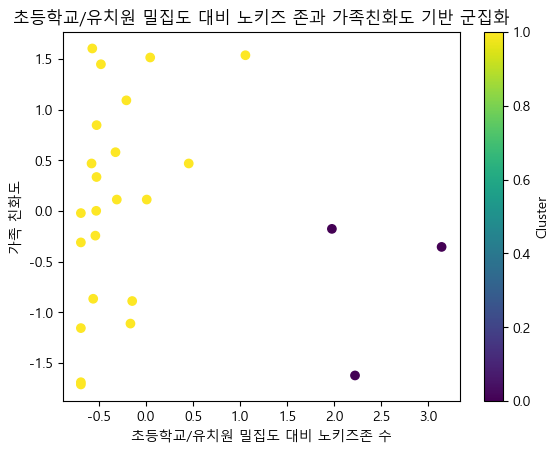

In [25]:
from sklearn.cluster import KMeans

# scaling
X = kmeans_df[['nokids_dens', '가족친화도']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans 클러스터링
kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
kmeans.fit(X_scaled)
labels = kmeans.labels_
kmeans_df['Cluster'] = labels

plt.rcParams['axes.unicode_minus'] = False
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis')
plt.xlabel('초등학교/유치원 밀집도 대비 노키즈존 수')
plt.ylabel('가족 친화도')
plt.title('초등학교/유치원 밀집도 대비 노키즈 존과 가족친화도 기반 군집화')
plt.colorbar(label='Cluster')
plt.show()